In [1]:
from SafeTransformer import SafeTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import random
import matplotlib.pyplot as plt
from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [2]:
apartments = pd.read_csv('apartments.csv', index_col=0)

In [3]:
X_ap = apartments.drop(columns='m2.price')
y = apartments['m2.price']

In [4]:
X = X_ap.copy()
colnames = list(X)
for idx, name in enumerate(colnames):
    if str(X.loc[:, name].dtype) in ['category', 'object']:
        dummies = pd.get_dummies(X.loc[:, name], prefix=name, drop_first=True)
        dummy_index  = X.columns.get_loc(name)
        X = pd.concat([X.iloc[:,range(dummy_index)], dummies, X.iloc[:, range(dummy_index+1, len(X.columns))]], axis=1)

In [5]:
X_train, X_test, X_lin_train, X_lin_test, y_train, y_test = train_test_split(X_ap, X, y, random_state =123)

# SAFE

In [6]:
linear_model = LinearRegression()

linear_model = linear_model.fit(X_lin_train, y_train)
standard_predictions = linear_model.predict(X_lin_test)
standard_predictions_error = mean_squared_error(y_test, standard_predictions)
standard_predictions_error

75683.04382573713

In [7]:
surrogate_model = GradientBoostingRegressor(random_state=123)
surrogate_model = surrogate_model.fit(X_lin_train, y_train)
surrogate_model_predictions = surrogate_model.predict(X_lin_test)
surrogate_model_predictions_error = mean_squared_error(y_test, surrogate_model_predictions)
surrogate_model_predictions_error

10625.472581948217

In [8]:
pens = np.linspace(0.01, 10, 25)
best_score = float('Inf')
best_pen = 0
errors = [] 

for pen in pens:
    surrogate_model = GradientBoostingRegressor(n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        loss='huber', random_state = 123)
    linear_model_simple = LinearRegression()
    safe_transformer = SafeTransformer(surrogate_model, penalty = pen)
    pipe = Pipeline(steps=[('safe', safe_transformer), ('linear', linear_model_simple)])
    pipe = pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    error = mean_squared_error(y_test, predictions)
    errors.append(error)
    print([pen, error])
    if error < best_score:
        best_score = error
        best_pen = pen

[0.01, 1226.4494460025637]
[0.42625, 1221.1439725589419]
[0.8425, 1213.8093534138357]
[1.25875, 1222.5356868966792]
[1.675, 1223.3542842423603]
[2.0912499999999996, 1203.9436057655528]
[2.5075, 1212.0728281572124]
[2.92375, 1202.7903424580497]
[3.34, 1193.3532434113338]
[3.7562499999999996, 1197.2197142262958]
[4.172499999999999, 1167.5207299540584]
[4.58875, 1164.9099564365151]
[5.005, 1164.5000542491505]
[5.42125, 1166.8123720966678]
[5.8375, 1188.7918492843594]
[6.25375, 1188.7918492843594]
[6.67, 1190.1063369259732]
[7.08625, 1198.516855711671]
[7.5024999999999995, 1203.9403351113915]
[7.91875, 1206.0547930068567]
[8.334999999999999, 1187.229376579732]
[8.75125, 1191.908046232663]
[9.1675, 1193.5724896039242]
[9.58375, 1195.217718747794]
[10.0, 1195.217718747794]


In [9]:
best_score

1164.5000542491505

# Plot

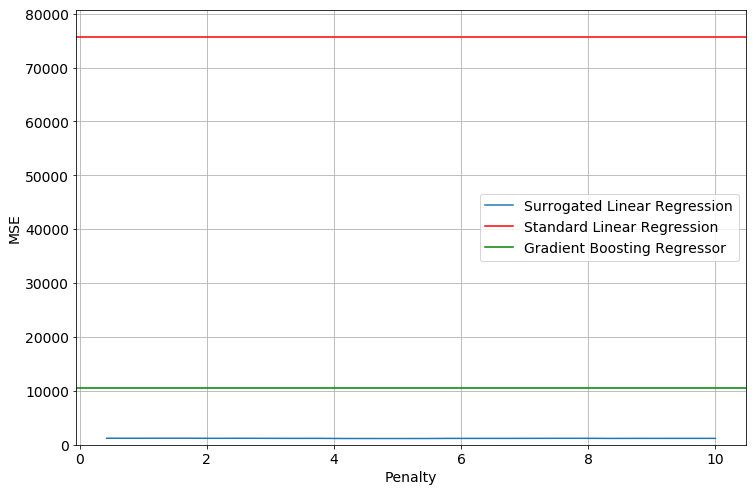

In [10]:
standard_error = mean_squared_error(y_test, standard_predictions)
xgb_error = mean_squared_error(y_test, surrogate_model_predictions)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 14})
plt.plot(pens[1:], errors[1:], label='Surrogated Linear Regression')
plt.xlabel('Penalty')
plt.ylabel('MSE')
plt.grid(True)
plt.axhline(standard_error, color='r', label='Standard Linear Regression')
plt.axhline(xgb_error, color='g', label='Gradient Boosting Regressor')
plt.ylim((0, max(max(errors[1:])+5000, standard_error+5000)))
plt.legend()
plt.show()

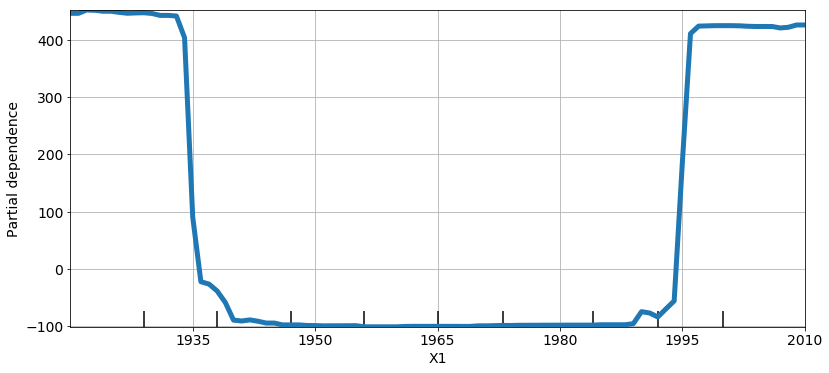

In [11]:
f, axis = plot_partial_dependence(surrogate_model, X, [0],
                                   figsize=[12, 8],
                                 line_kw = {"linewidth": 5}) 
plt.axvline(-2.28,  linewidth=3.0)
plt.axvline(2.49,  linewidth=3.0)
# plt.ylim(, 1.43)
plt.xlim(min(X["construction.year"]), max(X["construction.year"]))
plt.xlabel('X1')
# plt.ylabel('Average Response')
plt.grid(True)

# f.savefig("boston_PDP_ZN.pdf", bbox_inches='tight')

In [14]:
standard_predictions_error/ surrogate_model_predictions_error

7.1227931973883445

In [15]:
standard_predictions_error / best_score

64.99187659938431